In [1]:
import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import umap
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "IPAexGothic"  #'Times New Roman'

In [3]:
data = pd.read_csv('../input/tsta_a_1791676_sm7407.csv')
data

,ID,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),2% proof stress (Mpa),Tensile strength (Mpa),Elongation (%)
0,A 5005 P,1,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,95,125,2
1,A 5005 P,1,4,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,120,145,2
2,A 5005 P,1,6,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,145,165,2
3,A 5005 P,1,8,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,165,185,2
4,A 5005 P,2,2,0.35,0.1,0.15,98.33,0.8,0.0,0.1,0.05,0.125,85,120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,A 5N01 P,1,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,115,125,3
111,A 5N01 P,1,6,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,135,145,2
112,A 5N01 P,3,2,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,85,120,4
113,A 5N01 P,3,4,0.13,0.1,0.08,99.19,0.4,0.0,0.1,0.00,0.015,105,140,3


In [4]:
params = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state":42,
    "max_depth": 5,
    "n_estimators": 1000, 
    "colsample_bytree": 0.7,
}

In [ ]:
# 説明変数と目的変数
wt_columns = [col for col in data.columns if '(wt%)' in col]
additional_features = ['X', 'n']
all_features = wt_columns + additional_features
X = data[all_features]
y_elongation = data["Elongation (%)"]
y_proof_stress = data["2% proof stress (Mpa)"]

# トレーニングとテストデータに分割
X_train, X_test, y_train_elongation, y_test_elongation = train_test_split(
    X, y_elongation, test_size=0.2, random_state=42
)
_, _, y_train_proof_stress, y_test_proof_stress = train_test_split(
    X, y_proof_stress, test_size=0.2, random_state=42
)

# 学習データ用LightGBMモデルのトレーニング
model_elongation = lgb.LGBMRegressor(**params, verbose=-1)
model_proof_stress = lgb.LGBMRegressor(**param, verbose=-1)

model_elongation.fit(X_train, y_train_elongation)
model_proof_stress.fit(X_train, y_train_proof_stress)

# テストデータでの予測値
y_pred_elongation = model_elongation.predict(X_test)
y_pred_proof_stress = model_proof_stress.predict(X_test)

In [6]:
# 指標計算関数
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# Elongation (%) の評価指標
r2_elongation, rmse_elongation, mae_elongation = calculate_metrics(y_test_elongation, y_pred_elongation)

# 2% proof stress (Mpa) の評価指標
r2_proof_stress, rmse_proof_stress, mae_proof_stress = calculate_metrics(y_test_proof_stress, y_pred_proof_stress)

Text(0.5, 1.0, 'Elongation (%) - Prediction vs Actual\n')

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


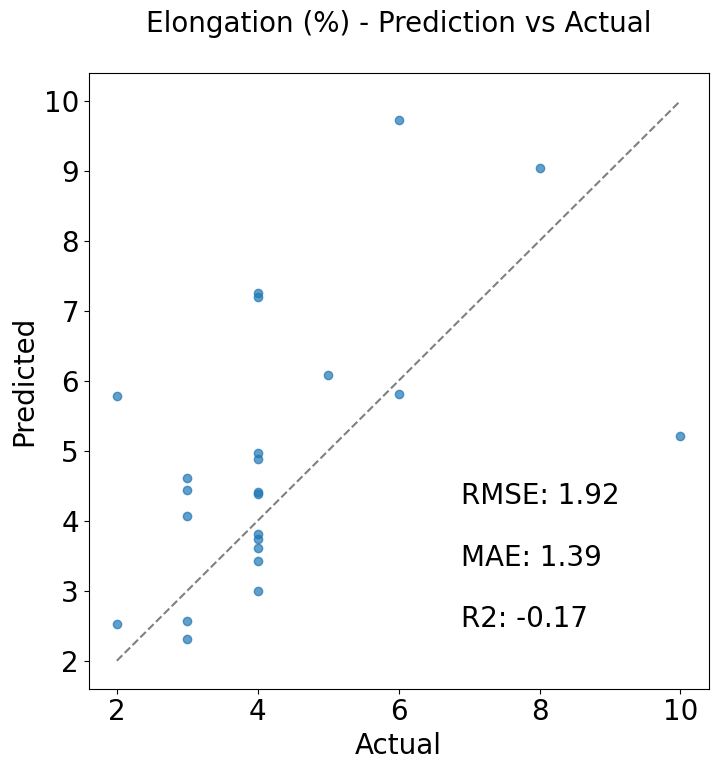

In [7]:
## Elongation (%) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_elongation, y_pred_elongation, alpha=0.7)
plt.plot(
    [y_test_elongation.min(), y_test_elongation.max()],
    [y_test_elongation.min(), y_test_elongation.max()],
    '--',
    color="gray",
    label="truth"
)
plt.text(
        0.6, 0.3, f"RMSE: {rmse_elongation:.2f}", transform=plt.gca().transAxes
    )
plt.text(
    0.6, 0.2, f"MAE: {mae_elongation:.2f}", transform=plt.gca().transAxes
)
plt.text(0.6, 0.1, f"R2: {r2_elongation:.2f}", transform=plt.gca().transAxes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Elongation (%) - Prediction vs Actual\n')

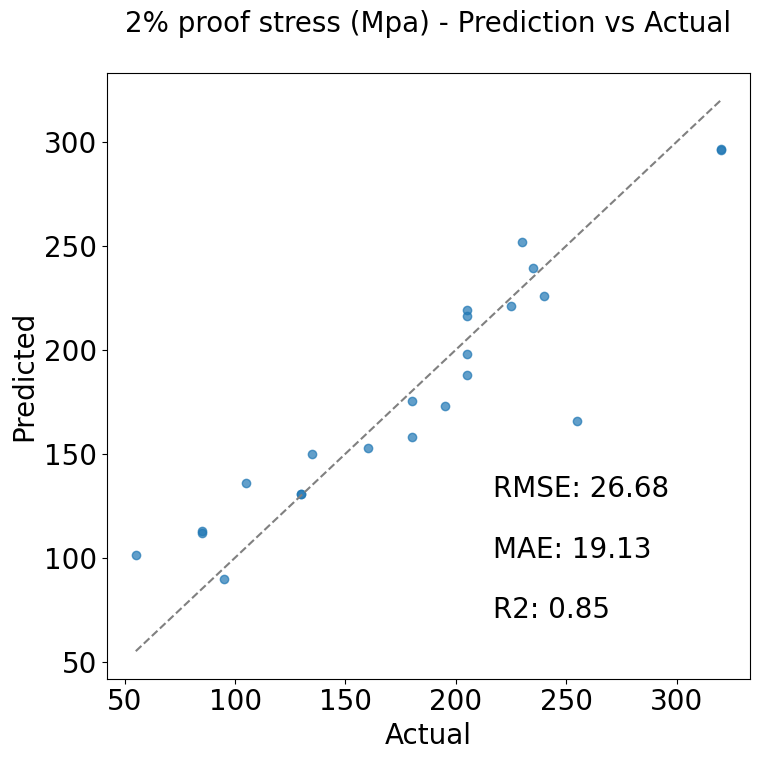

In [8]:
# 2% proof stress (Mpa) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_proof_stress, y_pred_proof_stress, alpha=0.7)
plt.plot(
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    [y_test_proof_stress.min(), y_test_proof_stress.max()],
    '--',
    color="gray",
    label="truth"
)

plt.text(
        0.6, 0.3, f"RMSE: {rmse_proof_stress:.2f}", transform=plt.gca().transAxes
    )
plt.text(
    0.6, 0.2, f"MAE: {mae_proof_stress:.2f}", transform=plt.gca().transAxes
)
plt.text(0.6, 0.1, f"R2: {r2_proof_stress:.2f}", transform=plt.gca().transAxes)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'2% proof stress (Mpa) - Prediction vs Actual\n')

plt.tight_layout()
plt.show()

In [ ]:
# OptunaでElongation (%)のハイパーパラメータmin_data_in_leafをチューニング
def objective(trial):
    params = {
        "objective": "regression",
        "learning_rate": 0.01,
        "reg_alpha": 0.1,
        "reg_lambda": 0.1,
        "random_state":42,
        "max_depth": 5,
        "n_estimators": 1000, 
        "colsample_bytree": 0.7,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 30, step=5),
    }
    model = lgb.LGBMRegressor(**params, verbose=-1)
    model.fit(X_train, y_train_elongation)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test_elongation, y_pred, squared=False)

sampler = optuna.samplers.TPESampler(seed=42)   
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100)

# チューニング後のハイパーパラメータ
best_params = study.best_params
best_params

[I 2024-12-05 12:48:55,666] A new study created in memory with name: no-name-b39750f4-62a0-46e2-9fc6-beda454d17eb


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2024-12-05 12:48:56,282] Trial 0 finished with value: 1.865636313118617 and parameters: {'min_data_in_leaf': 15}. Best is trial 0 with value: 1.865636313118617.
[I 2024-12-05 12:48:56,424] Trial 1 finished with value: 2.103559933633798 and parameters: {'min_data_in_leaf': 30}. Best is trial 0 with value: 1.865636313118617.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2024-12-05 12:48:56,602] Trial 2 finished with value: 1.9103847967166399 and parameters: {'min_data_in_leaf': 25}. Best is trial 0 with value: 1.865636313118617.
[I 2024-12-05 12:48:56,711] Trial 3 finished with value: 1.9167016537342731 and parameters: {'min_data_in_leaf': 20}. Best is trial 0 with value: 1.865636313118617.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:48:57,080] Trial 4 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:48:57,305] Trial 5 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:48:57,519] Trial 6 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:48:57,620] Trial 7 finished with value: 2.103559933633798 and parameters: {'min_data_in_leaf': 30}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2024-12-05 12:48:57,726] Trial 8 finished with value: 1.9167016537342731 and parameters: {'min_data_in_leaf': 20}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:48:57,822] Trial 9 finished with value: 1.9103847967166399 and parameters: {'min_data_in_leaf': 25}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:48:58,017] Trial 10 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:48:58,789] Trial 11 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:48:59,194] Trial 12 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:48:59,522] Trial 13 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:00,176] Trial 14 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2024-12-05 12:49:00,595] Trial 15 finished with value: 1.865636313118617 and parameters: {'min_data_in_leaf': 15}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:00,771] Trial 16 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:01,038] Trial 17 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:01,191] Trial 18 finished with value: 1.865636313118617 and parameters: {'min_data_in_leaf': 15}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:01,470] Trial 19 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:01,726] Trial 20 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:01,999] Trial 21 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:02,819] Trial 22 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:03,087] Trial 23 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:03,411] Trial 24 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:03,706] Trial 25 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:04,068] Trial 26 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:04,233] Trial 27 finished with value: 1.865636313118617 and parameters: {'min_data_in_leaf': 15}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:04,502] Trial 28 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:04,651] Trial 29 finished with value: 1.865636313118617 and parameters: {'min_data_in_leaf': 15}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:04,869] Trial 30 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:05,152] Trial 31 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:05,643] Trial 32 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:05,971] Trial 33 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:06,168] Trial 34 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:07,094] Trial 35 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:07,275] Trial 36 finished with value: 1.9103847967166399 and parameters: {'min_data_in_leaf': 25}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2024-12-05 12:49:07,449] Trial 37 finished with value: 1.9167016537342731 and parameters: {'min_data_in_leaf': 20}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:07,572] Trial 38 finished with value: 2.103559933633798 and parameters: {'min_data_in_leaf': 30}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:07,812] Trial 39 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:08,118] Trial 40 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:08,445] Trial 41 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:08,743] Trial 42 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:09,332] Trial 43 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:09,542] Trial 44 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:09,769] Trial 45 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:10,715] Trial 46 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:11,183] Trial 47 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:11,633] Trial 48 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:11,937] Trial 49 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:12,100] Trial 50 finished with value: 1.9167016537342731 and parameters: {'min_data_in_leaf': 20}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:12,409] Trial 51 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:12,719] Trial 52 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:13,039] Trial 53 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:13,245] Trial 54 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:13,890] Trial 55 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:14,439] Trial 56 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:15,231] Trial 57 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:15,443] Trial 58 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:15,625] Trial 59 finished with value: 1.9103847967166399 and parameters: {'min_data_in_leaf': 25}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:15,873] Trial 60 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:16,217] Trial 61 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:16,726] Trial 62 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:17,045] Trial 63 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:17,413] Trial 64 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:17,735] Trial 65 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:17,934] Trial 66 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:18,529] Trial 67 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:18,882] Trial 68 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:19,168] Trial 69 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:19,347] Trial 70 finished with value: 1.865636313118617 and parameters: {'min_data_in_leaf': 15}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:19,673] Trial 71 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:19,977] Trial 72 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:20,285] Trial 73 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:20,619] Trial 74 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:23,525] Trial 75 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:24,038] Trial 76 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:24,349] Trial 77 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:24,779] Trial 78 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:25,178] Trial 79 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:25,549] Trial 80 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:25,907] Trial 81 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:26,547] Trial 82 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:27,131] Trial 83 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:27,479] Trial 84 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:27,854] Trial 85 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:28,079] Trial 86 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.
[I 2024-12-05 12:49:28,274] Trial 87 finished with value: 2.103559933633798 and parameters: {'min_data_in_leaf': 30}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:28,638] Trial 88 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:29,107] Trial 89 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:30,107] Trial 90 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:30,680] Trial 91 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:31,051] Trial 92 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:31,445] Trial 93 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:31,867] Trial 94 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-12-05 12:49:32,175] Trial 95 finished with value: 2.0757070890148337 and parameters: {'min_data_in_leaf': 10}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:32,538] Trial 96 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:33,494] Trial 97 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:33,893] Trial 98 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-12-05 12:49:34,454] Trial 99 finished with value: 0.979291123533478 and parameters: {'min_data_in_leaf': 5}. Best is trial 4 with value: 0.979291123533478.


{'min_data_in_leaf': 5}

In [14]:
params_opt = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state":42,
    "max_depth": 5,
    "n_estimators": 1000, 
    "colsample_bytree": 0.7,
    'min_data_in_leaf': 5
}

In [15]:
model_elongation_opt = lgb.LGBMRegressor(**params_opt)

model_elongation_opt.fit(X_train, y_train_elongation)

y_pred_elongation_opt = model_elongation_opt.predict(X_test)

r2_elongation_opt, rmse_elongation_opt, mae_elongation_opt = calculate_metrics(y_test_elongation, y_pred_elongation_opt)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Text(0.5, 1.0, 'Elongation (%) - Prediction_opt vs Actual\n')

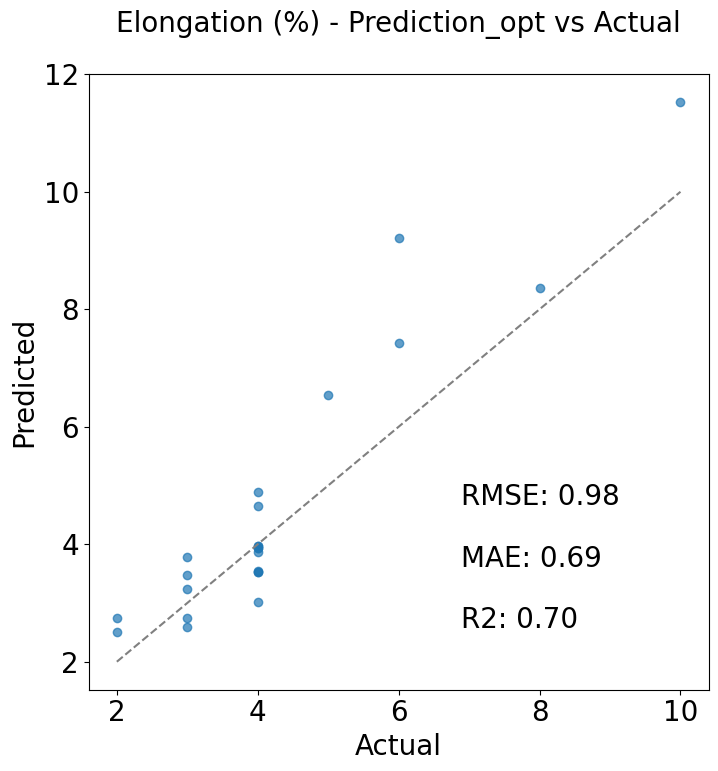

In [16]:
## Elongation (%)のハイパーパラメータmin_data_in_leafをチューニングした後のElongation (%) のプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_test_elongation, y_pred_elongation_opt, alpha=0.7)
plt.plot(
    [y_test_elongation.min(), y_test_elongation.max()],
    [y_test_elongation.min(), y_test_elongation.max()],
    '--',
    color="gray",
    label="truth"
)
plt.text(
        0.6, 0.3, f"RMSE: {rmse_elongation_opt:.2f}", transform=plt.gca().transAxes
    )
plt.text(
    0.6, 0.2, f"MAE: {mae_elongation_opt:.2f}", transform=plt.gca().transAxes
)
plt.text(0.6, 0.1, f"R2: {r2_elongation_opt:.2f}", transform=plt.gca().transAxes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Elongation (%) - Prediction_opt vs Actual\n')